<a href="https://colab.research.google.com/github/SabriMendoza/7506R-1C2023-GRUPO33/blob/main/7506R_TP1_GRUPO33_CHP4_ENTREGA_N1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Trabajo practico 1: Reserva de Hotel

Grupo 33

Integrantes:
1.   Mendoza Hernandez, Sabrina Scarlet (108524)
2.   Valeriani, Matias Gabriel (108570)
3.   Jang, Lucas (109151)


#Importar librerias

In [1]:
#datos
import numpy as np
import pandas as pd

#Plots
import matplotlib.pyplot as plt
import seaborn as sns

#Modelado
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, classification_report , f1_score, precision_score, make_scorer, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix


import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier  

# import visualkeras
np.random.seed(1)
tf.random.set_seed(1) 

#Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

#Matriz de confusión y metricas a considerar

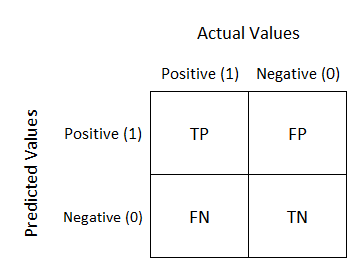

TP: True Positive (verdaderos positivos)

FP: False Positive (falsos positivos)

FN: False Negative (falsos negativos)

TN: True Negative (verdaderos negativos)

Las métricas que consideraremos, se calculan a partir de los datos brindados en la matriz de confusion. Con esta matriz se puede obtener precision, recall, f1 score y accuracy. 

* La precisión (**precision**) mide la proporción de verdaderos positivos (TP) entre los casos positivos pronosticados (TP + FP). Mide la capacidad del modelo para predecir correctamente los casos positivos.

  $Precision = \frac{TP}{TP + FP}$

* El recall (**recall**) mide la proporción de verdaderos positivos (TP) entre todos los casos positivos reales (TP + FN). Mide la capacidad del modelo para encontrar todos los casos positivos.

  $Recall = \frac{TP}{TP + FN}$

* El F1 score (**f1 score**) es la media armónica entre la precisión y el recall. Resume el rendimiento del modelo en términos de clasificación.

  $F1 Score = 2\frac{Precision.Recall}{Precision + Recall}$

* La exactitud (**accuracy**) mide la proporción de casos totales que se clasifican correctamente (TP + TN) sobre el total de casos (TP + TN + FP + FN). Mide la capacidad del modelo para clasificar correctamente todos los casos, tanto positivos como negativos.

  $Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$

# Preparacion de los dataframes

## Dataframe train

In [2]:
reservas = pd.read_csv("https://drive.google.com/uc?export=download&id=1fvs0y1EqWpmx_ZuhlSEzFjwCI0HZGCxv")
hotels = reservas.copy()
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60679 entries, 0 to 60678
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   lead_time                       60679 non-null  int64  
 1   arrival_date_year               60679 non-null  int64  
 2   arrival_date_week_number        60679 non-null  int64  
 3   adults                          60679 non-null  int64  
 4   children                        60679 non-null  int64  
 5   is_repeated_guest               60679 non-null  int64  
 6   previous_cancellations          60679 non-null  int64  
 7   previous_bookings_not_canceled  60679 non-null  int64  
 8   booking_changes                 60679 non-null  int64  
 9   agent                           60679 non-null  float64
 10  days_in_waiting_list            60679 non-null  int64  
 11  adr                             60679 non-null  float64
 12  required_car_parking_spaces     

* Dividimos las variables por un lado, y el target *is_canceled* por el otro, haciendo dataframes para cada caso. Posteriormente separamos en *x_train, x_test, y_train, y_test*


In [3]:
hotels_train = hotels.copy()
#hotels_train.drop('id', axis='columns', inplace=True)

target = 'is_canceled'
features = hotels.columns.tolist()
features.remove(target)

#Features
features_para_clasificar = hotels_train.columns.tolist()
features_para_clasificar.remove(target)
df_train_completo_x = hotels_train[features_para_clasificar]

#Target
df_train_completo_y = hotels_train[target].copy()

x_train, x_test, y_train, y_test = train_test_split(df_train_completo_x, 
                                                    df_train_completo_y, 
                                                    test_size=0.20, #20% al conjunto de test
                                                    random_state=13)

# Funciones Auxiliares

* Función auxiliar *metricas(y_pred, y_test)* para mostrar la matriz de confusión con sus respectivas métricas encontradas.

In [4]:
def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))
  
  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='YlOrRd',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

## Normalizacion de Datos 

Realizamos dos etapas de preprocesamiento de datos: codificación one-hot y escalado estándar. OneHotEncoder se utiliza para codificar variables categóricas y convertirlas en características numéricas, mientras que StandardScaler se utiliza para estandarizar características numéricas y asegurarse de que estén en una escala similar.

In [5]:
enc = OneHotEncoder()
y_train_encoder = enc.fit_transform(y_train[:, np.newaxis]).toarray()
y_test_encoder = enc.transform(y_test[:, np.newaxis]).toarray()

scaler=StandardScaler()
x_train_norm = scaler.fit_transform(x_train) 
x_test_norm  = scaler.transform(x_test)

## Dataframe test

* Cargamos el dataset de test para guardarnos el id, luego cargaremos el que ya esta procesado con los features requeridos

El siguiente nos servirá unicamente para guardarnos el *id*

In [6]:
reservas_test = pd.read_csv("https://drive.google.com/uc?export=download&id=1-5FFQZp2NmEqpBDGCD17e0QM0_AF7Ht2")
hotels_test = reservas_test.copy()

*hotels_test_* nos servirá para testear nuestro modelo y generar las predicciones que subiremos a Kaggle.

In [7]:
test = pd.read_csv("https://drive.google.com/uc?export=download&id=1OVHmmfGCqK_U1i404zGn5vVQPqh7aHuN")
hotels_test_ = test.copy()
hotels_test_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26535 entries, 0 to 26534
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   lead_time                       26535 non-null  int64  
 1   arrival_date_year               26535 non-null  int64  
 2   arrival_date_week_number        26535 non-null  int64  
 3   adults                          26535 non-null  int64  
 4   children                        26535 non-null  int64  
 5   is_repeated_guest               26535 non-null  int64  
 6   previous_cancellations          26535 non-null  int64  
 7   previous_bookings_not_canceled  26535 non-null  int64  
 8   booking_changes                 26535 non-null  int64  
 9   agent                           26535 non-null  float64
 10  days_in_waiting_list            26535 non-null  int64  
 11  adr                             26535 non-null  float64
 12  required_car_parking_spaces     

# Red Neuronal: Clasificacion


## Modelo

* El modelo descrito a continuacion es una red neuronal con dos capas ocultas de 64 unidades cada una, y una capa de salida con un número de unidades igual al número de clases en los datos. La capa de entrada (input_shape=(d_in,)) tiene 64 neuronas y utiliza la función de activación ReLU, al igual que la otra capa oculta. La capa de salida tiene un número de neuronas igual a la cantidad de clases (cant_clases) y utiliza la función de activación sigmoide.

In [8]:
cant_clases=len(np.unique(df_train_completo_y))
d_in=len(features_para_clasificar)

modelo = keras.Sequential([
    keras.layers.Dense(64,input_shape=(d_in,), activation='relu', kernel_initializer='uniform'),
    keras.layers.Dense(64,activation='relu'),
    keras.layers.Dense(cant_clases, activation='sigmoid')])

modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2688      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 6,978
Trainable params: 6,978
Non-trainable params: 0
_________________________________________________________________


Se configura el modelo para el entrenamiento especificando el optimizador, la función de pérdida y las métricas de evaluación. Luego, se entrena el modelo utilizando los datos de entrenamiento y se especifican los parámetros de entrenamiento, como el número de epochs y el batch_size.

In [9]:
modelo.compile(
  optimizer=keras.optimizers.Nadam(learning_rate=0.001), 
  loss='categorical_crossentropy', 
  # metricas para ir calculando en cada iteracion o batch 
  metrics=['AUC'], 
)

cant_epochs=100
historia_modelo = modelo.fit(x_train_norm,y_train_encoder,epochs=cant_epochs,batch_size=100,verbose=False)

In [10]:
y_pred = modelo.predict(x_test_norm)

380/380 [==============================] - 1s 2ms/step


In [11]:
y_pred.shape

(12136, 2)

              precision    recall  f1-score   support

           0       0.86      0.81      0.84      6108
           1       0.82      0.87      0.84      6028

    accuracy                           0.84     12136
   macro avg       0.84      0.84      0.84     12136
weighted avg       0.84      0.84      0.84     12136

f1 score: 0.8442973605617887


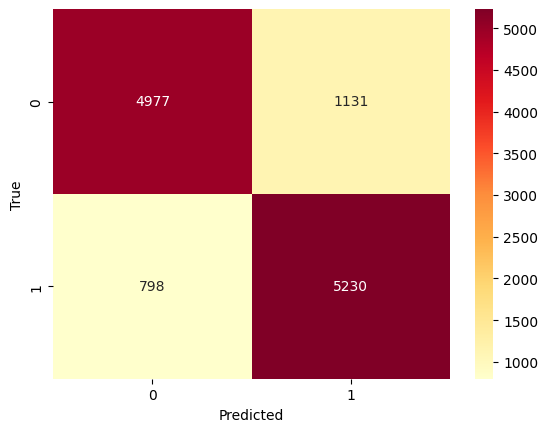

In [12]:
y_pred_clases=np.argmax(y_pred,axis=1).tolist()
y_test_clases=np.argmax(y_test_encoder,axis=1).tolist()

metricas(y_pred_clases, y_test_clases)
f1=f1_score(y_test_clases,y_pred_clases)
print("f1 score: "+str(f1))

* Trazamos un gráfico que muestra la métrica AUC en función del número de epochs durante el entrenamiento del modelo. El eje x representa los epochs mientras que el eje y representa el valor de AUC.

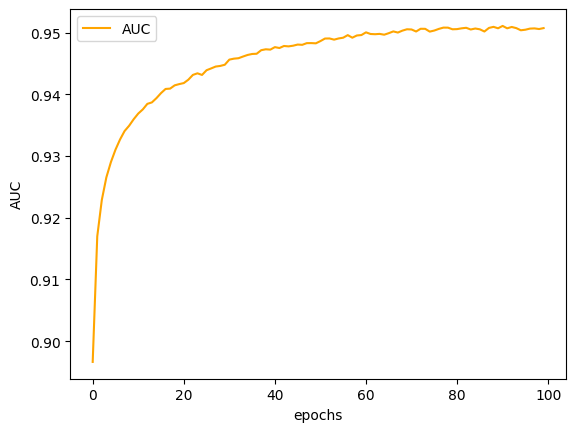

In [13]:
epochs = range(cant_epochs)

plt.plot(epochs, historia_modelo.history['auc'], color='orange', label='AUC')
plt.xlabel("epochs")
plt.ylabel("AUC")
plt.legend()

#Predicciones en el dataframe test.

* Para hacer el submission con el dataset de test, primero aplicamos la transformación de escala a los datos de prueba, luego obtuvimos las predicciones, y finalmente antes de convertir a csv, #convertimos las predicciones a clases.

In [14]:
hotels_test_norm = scaler.transform(hotels_test_)
y_pred = modelo.predict(hotels_test_norm)

y_pred_classes = np.argmax(y_pred, axis=1)

df_submission = pd.DataFrame({'id': hotels_test['id'], 'is_canceled': y_pred_classes})
df_submission.head(10)

830/830 [==============================] - 1s 1ms/step


,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1
5,c142b61c-3035-46e7-8cf7-3720a29d0d61,1
6,8c4171ad-9837-4468-ac8e-8cb3d5a41b55,1
7,3ce60033-4529-4314-be77-db4a7737f326,1
8,7ab807a4-5e90-4205-b66e-0188696cc34b,1
9,a0ab0509-c8b0-4a2c-9f27-21f26e186520,0


In [15]:
df_submission.to_csv('submission_redes_neuronales.csv', index=False)